In [59]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os
import matplotlib.pyplot as plt

In [60]:
# --- 1. Data Paths ---
base_dir = '/Users/sreehari/PycharmProjects/FInal_Project/datasets/Alzheimer'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [61]:
# --- 2. Class Imbalance Handling ---
img_width, img_height = 128, 128 

train_datagen_no_aug = ImageDataGenerator(rescale=1./255)
train_generator_no_aug = train_datagen_no_aug.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical'
)

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator_no_aug.classes),
    y=train_generator_no_aug.classes
)
class_weight_dict = dict(enumerate(class_weights))

Found 25024 images belonging to 3 classes.


In [62]:

# --- 3. Data Preprocessing and Augmentation --- 
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical'
)
validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical'
)


Found 25024 images belonging to 3 classes.
Found 5004 images belonging to 3 classes.
Found 3446 images belonging to 3 classes.


In [63]:
# --- 4. Custom CNN Model --- 
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001),
input_shape=(img_width, img_height, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

In [64]:
# Display the model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 14, 14, 128)     

In [65]:

# --- 5. Compile and Train ---
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator
)

Epoch 1/20


2024-05-12 09:55:22.705187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - ETA: 0s - loss: 0.7165 - accuracy: 0.6873

2024-05-12 09:56:20.023900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 61s 78ms/step - loss: 0.7165 - accuracy: 0.6873 - val_loss: 0.4285 - val_accuracy: 0.8201
Epoch 2/20
782/782 [==============================] - 62s 80ms/step - loss: 0.4438 - accuracy: 0.8243 - val_loss: 0.3710 - val_accuracy: 0.8377
Epoch 3/20
782/782 [==============================] - 69s 88ms/step - loss: 0.3732 - accuracy: 0.8590 - val_loss: 0.2727 - val_accuracy: 0.9199
Epoch 4/20
782/782 [==============================] - 72s 92ms/step - loss: 0.3305 - accuracy: 0.8802 - val_loss: 0.2541 - val_accuracy: 0.9231
Epoch 5/20
782/782 [==============================] - 74s 95ms/step - loss: 0.2960 - accuracy: 0.8971 - val_loss: 0.1868 - val_accuracy: 0.9472
Epoch 6/20
782/782 [==============================] - 73s 94ms/step - loss: 0.2723 - accuracy: 0.9096 - val_loss: 0.1831 - val_accuracy: 0.9516
Epoch 7/20
782/782 [==============================] - 75s 95ms/step - loss: 0.2547 - accuracy: 0.9172 - val_loss: 0.2133 - val_accuracy: 0.9363
Epo

In [66]:

# --- 6. Evaluate the Model ---
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

108/108 [==============================] - 4s 36ms/step - loss: 0.0733 - accuracy: 0.9968
Test accuracy: 0.996807873249054


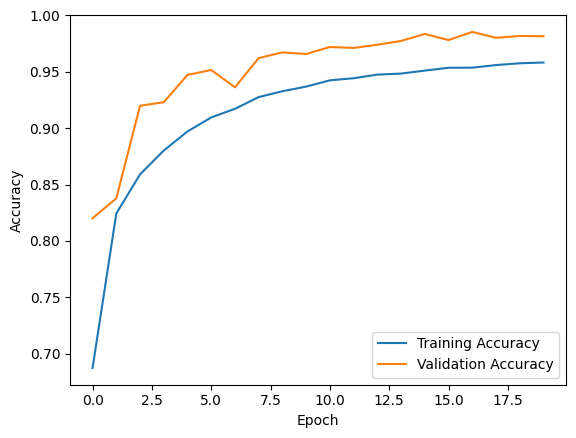

In [67]:
# --- 7. Plot Accuracy ---
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [71]:

# --- 7. Save the Model  ---
model.save('alzheimers_model.h5')